References: Chapter 17 of Geron's book. For 1-Dim plots, Keras tutorial : https://www.tensorflow.org/tutorials/generative/autoencoder

This file trains a modified VAE (with a different sampling layer and a different loss function) with the instances of the normal ECGs in the training data. Then, it measures the reconstruction loss for the ECGs in the test data. The reconstruction loss for the instances of the abnormal ECGs in the test data is higher. A threshold is determined based on the distribution of the reconstruction losses of the normal training data (threshold = mean + 2.5*std of this distribution). Then, if the reconstruction loss of a ECG in the test data is higher than this threshold, it is classified as abnormal. By comparing with the known labels of test data (with T for normal ECG(s) and F for abnormal ECG(s)), the confusion matrix and the accuracy is calculated.

Import the necessary libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.models import Model

Loading the ECG5000 data:

In [2]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


Parse the data so it can be split creating a variable containing the labels and another containing the data. Splitting the data into train, validation, and test set.

In [3]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

train_data, valid_data, train_labels, valid_labels = train_test_split(
    train_data, train_labels, test_size=.1, random_state=21
)

Normalize the data so the features are treated equally, normalizing using the overall min and max value of all training data (train/validation set).

In [4]:
min_val = tf.reduce_min(tf.concat([train_data, valid_data], 0))
max_val = tf.reduce_max(tf.concat([train_data, valid_data], 0))

train_data = (train_data - min_val) / (max_val - min_val)
valid_data = (valid_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
valid_data = tf.cast(valid_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

The autoencoder is trained using only the normal rhythms, which are labeled in this dataset as 1. Here the normal rhythms is separated from the abnormal rhythms, and the labels are casted as type bool.

In [5]:
train_labels = train_labels.astype(bool)
valid_labels = valid_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_valid_data = valid_data[valid_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_valid_data = valid_data[~valid_labels]
anomalous_test_data = test_data[~test_labels]

Initialize K with the Keras backend to utilize it's methods in the Sampling function.

In [6]:
K = keras.backend

This Sampling layer takes two inputs: mean (μ) and log_var (γ). It uses the function K.random_normal() to sample a random vector (of the same shape as γ) from the Normal distribution, with mean 0 and standard deviation 1. Then it multiplies it by exp(γ/2) (which is equal to σ, as you can verify), and finally it adds μ and returns the result. This samples a codings vector from the Normal distribution with mean μ and standard deviation σ.

In [7]:
# Modified sampling layer with the addition of mean_2, log_var_2, and fraction p, with
# the appropriate change in the reparametrization trick to do stochastic 
# sampling from the superposition of the two MVN distributions, while allowing
# the 5 parallel layers containing the means and stds of the two MVNs and the fractions p's
# for each dimension to be trained via backpropogation of the error signal.
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean_1, log_var_1, mean_2, log_var_2, p = inputs
        return p*(K.random_normal(tf.shape(log_var_1))*K.exp(log_var_1/2)+mean_1) +  (1-p)*(K.random_normal(tf.shape(log_var_2))*K.exp(log_var_2/2)+mean_2)

Create the encoder, using the Functional API because the model is not
entirely sequential:

In [8]:
# For details please see Geron's book. 
codings_size = 8   # The number of dimensions of the MVN distribution in the sampling layer

inputs = keras.layers.Input(shape=(normal_train_data.shape[1]))
z = keras.layers.Dense(32, activation="selu")(inputs)
z = keras.layers.Dense(16, activation="selu")(z)

# Adding output nodes (parallel layers) at the end of the encoder for means 
# and standard deviations of a second Multivariate Normal (MVN) distribution 
# in the dimensions of the coding size (here 32). In each of the dimensions,
# this first MVN is multiplied by a fraction p and added to the second MVN
# multiplied by 1 - p in each dimension.
# final distribution = p * first MVN + (1 - p) * second MVN
# Another parallel layer (set of nodes) is added to keep and train the fractions p's
# in each dimension 
codings_mean_1 = keras.layers.Dense(codings_size)(z)
codings_log_var_1 = keras.layers.Dense(codings_size)(z)
codings_mean_2 = keras.layers.Dense(codings_size)(z)
codings_log_var_2 = keras.layers.Dense(codings_size)(z)
codings_p = keras.layers.Dense(1, activation='sigmoid')(z)
# codings_p = keras.layers.Dense(codings_size)(z) old


# Sampling layer at the end of the encoder
# Modified sampling layer at the end of the encoder
codings = Sampling()([codings_mean_1, codings_log_var_1, codings_mean_2, codings_log_var_2, codings_p])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean_1, codings_log_var_1, codings_mean_2, codings_log_var_2, codings_p, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(16, activation="selu")(decoder_inputs)
x = keras.layers.Dense(32, activation="selu")(x)
outputs = keras.layers.Dense(normal_train_data.shape[1], activation="sigmoid")(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, _, _, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

# New latent loss function that will be added to the reconstruction binary cross-entropy loss
# The whole network (Encoder, sampling layer, and decoder) will train to minimize this loss
p_mean = K.mean(codings_p)
array1 = p_mean*(codings_log_var_1 - K.exp(codings_log_var_1) - K.square(codings_mean_1))
array2 = (1-p_mean)*(codings_log_var_2 - K.exp(codings_log_var_2) - K.square(codings_mean_2))
sum1 = K.sum(1 + array1, axis=-1)
sum2 = K.sum(1 + array2, axis=-1)


latent_loss = -0.5 * (sum1 + sum2)
latent_loss *= .5

# Add the latent loss to the reconstruction loss
variational_ae.add_loss(K.mean(latent_loss) / 140.)

# For the reconstruction loss binary cross-entropy loss is used. 
# For details please see Chapter 17 of Geron's book (Stacked AE and VAE sections) 
variational_ae.compile(loss="mae", optimizer="adam")

history = variational_ae.fit(normal_train_data, normal_train_data, epochs=100, batch_size=512,
                             validation_data=(test_data, test_data), shuffle=True)

Epoch 1/100
5/5 [==============================] - 4s 132ms/step - loss: 0.1161 - val_loss: 0.0815
Epoch 2/100
5/5 [==============================] - 0s 22ms/step - loss: 0.0772 - val_loss: 0.0732
Epoch 3/100
5/5 [==============================] - 0s 27ms/step - loss: 0.0698 - val_loss: 0.0653
Epoch 4/100
5/5 [==============================] - 0s 25ms/step - loss: 0.0612 - val_loss: 0.0590
Epoch 5/100
5/5 [==============================] - 0s 24ms/step - loss: 0.0551 - val_loss: 0.0532
Epoch 6/100
5/5 [==============================] - 0s 23ms/step - loss: 0.0491 - val_loss: 0.0490
Epoch 7/100
5/5 [==============================] - 0s 32ms/step - loss: 0.0435 - val_loss: 0.0458
Epoch 8/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0385 - val_loss: 0.0418
Epoch 9/100
5/5 [==============================] - 0s 13ms/step - loss: 0.0339 - val_loss: 0.0385
Epoch 10/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0301 - val_loss: 0.0370
Epoch 11/100
5/5 [

Plotting the training and validation loss for each epoch of training:

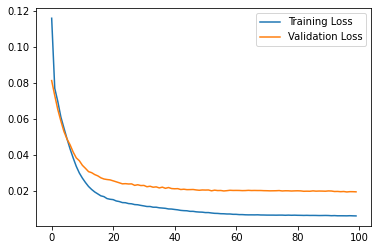

In [9]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

Plotting a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

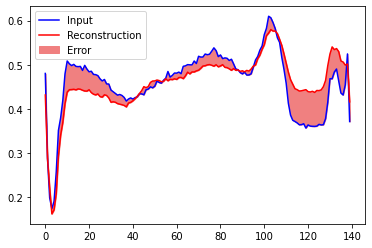

In [10]:
_, _, _, _, _, codings = variational_encoder(normal_test_data)
decoded_imgs = variational_decoder(codings)

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Now, we will do the same for the anomalous data:

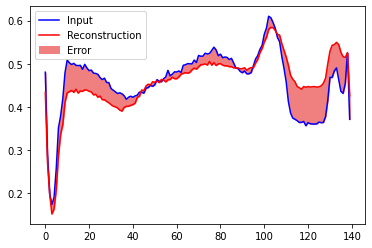

In [11]:
_, _, _, _, _, codings = variational_encoder(anomalous_test_data)
decoded_imgs = variational_decoder(codings)

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Here will compute the normal/abnormal train/validation loss from the model using mean absolute error.

In [12]:
# Normal reconstructions
reconstructions_train = variational_ae.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions_train, normal_train_data)
reconstructions_valid = variational_ae.predict(normal_valid_data)
valid_loss = tf.keras.losses.mae(reconstructions_valid, normal_valid_data)
# Abnormal reconstructions
ab_reconstructions_train = variational_ae.predict(anomalous_train_data)
ab_train_loss = tf.keras.losses.mae(ab_reconstructions_train, anomalous_train_data)
ab_reconstructions_valid = variational_ae.predict(anomalous_valid_data)
ab_valid_loss = tf.keras.losses.mae(ab_reconstructions_valid, anomalous_valid_data)

Defining a function predict which takes the model, data, and threshold. Computes the reconstruction loss and returns the truthy value for all elements if they are less than the threshold (True).

In [13]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

Computing the abnormal/normal mean of the validation loss

In [14]:
abnormal_valid_mean_loss = np.mean(ab_valid_loss)
normal_valid_mean_loss = np.mean(valid_loss)

Computing 100 different thresholds that start at the normal threshold and end at the abnormal threshold incrementing by their difference divided by 100.

In [15]:
increment = (abnormal_valid_mean_loss - normal_valid_mean_loss)/100
thresholds = np.arange(normal_valid_mean_loss, abnormal_valid_mean_loss, 
increment)

Creating a numpy array to store the accuracy for each of the different threshold values.

In [16]:
thresh_size = thresholds.shape[0]
accuracies = np.zeros(thresh_size)

Calculation of the threshold that gives the best accuracy on the validation data. This is done by going through all thresholds and testing the accuracy of the model with each threshold.

In [17]:
for i in range(thresh_size):
  preds = predict(variational_ae, valid_data, thresholds[i])
  accuracies[i] = accuracy_score(preds, valid_labels)

Setting the threshold to the one in thresholds which gave the best accuracy.

In [18]:
argmax = np.argmax(accuracies)
best_threshold = thresholds[argmax]
print("The best threshold based on validation data: ", best_threshold)

The best threshold based on validation data:  0.036079626809805705


We now detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold we just computed. We then will classify future examples as anomalous if the reconstruction error is higher than this threshold.

Plotting the reconstruction error on all ECGs from the training set

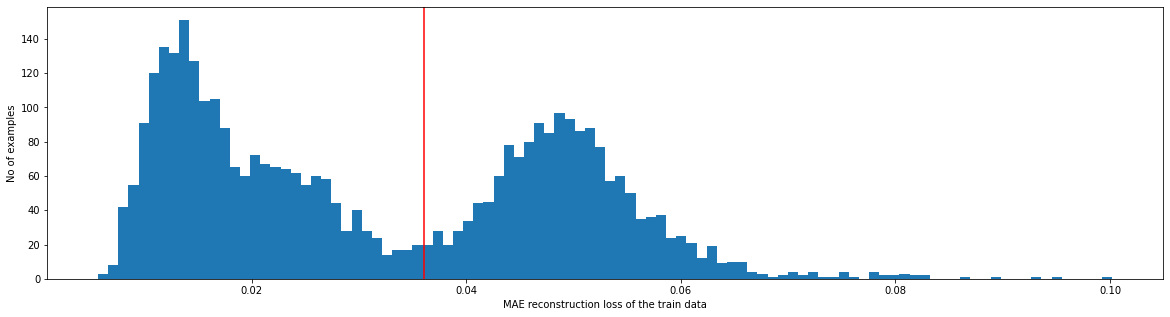

In [19]:
reconstructions = variational_ae.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)
plt.figure(figsize=(20,5))
plt.hist(train_loss[None,:], bins=100)
plt.axvline(best_threshold, c='r')
plt.xlabel("MAE reconstruction loss of the train data")
plt.ylabel("No of examples")
plt.show()

Plotting the reconstruction error on all ECGs from the validation set

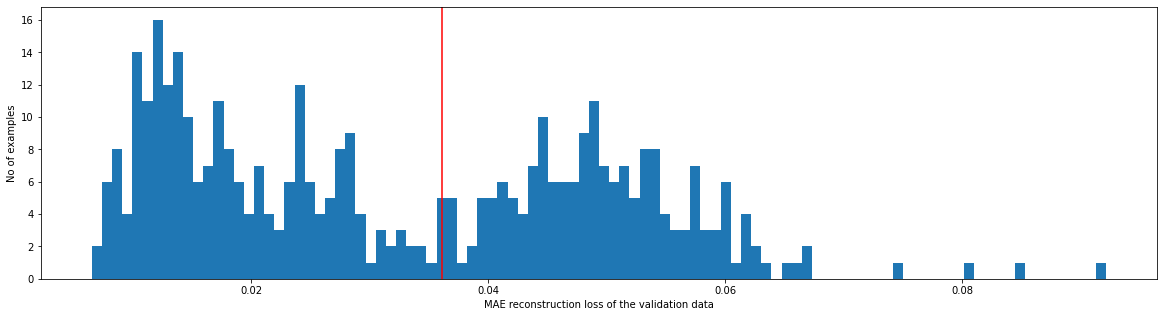

In [20]:
reconstructions = variational_ae.predict(valid_data)
valid_loss = tf.keras.losses.mae(reconstructions, valid_data)
plt.figure(figsize=(20,5))
plt.hist(valid_loss[None,:], bins=100)
plt.axvline(best_threshold, c='r')
plt.xlabel("MAE reconstruction loss of the validation data")
plt.ylabel("No of examples")
plt.show()

Plotting the reconstruction error on all ECGs from the test set

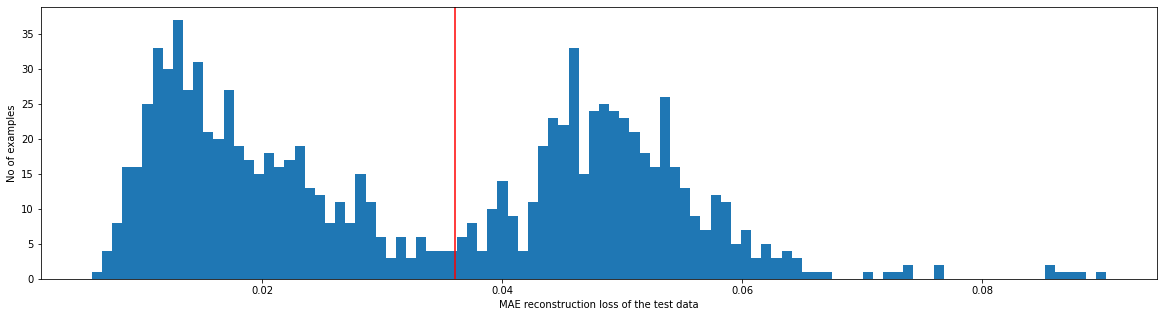

In [21]:
reconstructions = variational_ae.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions, test_data)
plt.figure(figsize=(20,5))
plt.hist(test_loss[None,:], bins=100)
plt.axvline(best_threshold, c='r')
plt.xlabel("MAE reconstruction loss of the test data")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [22]:
def print_stats(predictions, labels, model, data):
  cf = confusion_matrix(labels, predictions)
  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], labels[labels == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], labels[labels == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  reconstructions = model.predict(data[labels])
  nl_test_loss =  tf.keras.losses.mae(reconstructions, data[labels])
  print("Normal Test Data Mean = {}".format(np.mean(nl_test_loss)))
  print("Normal Test Data Standard Deviation = {}".format(np.std(nl_test_loss)))
  reconstructions = model.predict(data[~labels])
  ab_test_loss =  tf.keras.losses.mae(reconstructions, data[~labels])
  print("Abnormal Test Data Mean = {}".format(np.mean(ab_test_loss)))
  print("Abnormal Test Data Standard Deviation = {}".format(np.std(ab_test_loss)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [23]:
thr_acc = np.zeros((thresh_size, 2))
thr_acc[:, 0] = thresholds
thr_acc[:, 1] = accuracies
thr_acc[argmax - 2 : argmax + 3]

array([[0.03550995, 0.9425    ],
       [0.03579479, 0.9425    ],
       [0.03607963, 0.95      ],
       [0.03636446, 0.9425    ],
       [0.0366493 , 0.94      ]])

Calculation of the accuracy and the confusion matrix on the test data with threshold set based on the best threshold from the validation data

In [24]:
preds = predict(variational_ae, test_data, best_threshold)
print_stats(preds, test_labels, variational_ae, test_data)

Confusion Matrix: 
 prediction: F      T 
             465   535
 label: F   [[431   9]    440
        T    [34   526]]   560
Accuracy = 0.957
Normal Test Data Mean = 0.020130768418312073
Normal Test Data Standard Deviation = 0.011523047462105751
Abnormal Test Data Mean = 0.049706559628248215
Abnormal Test Data Standard Deviation = 0.008373000659048557
Precision = 0.983177570093458
Recall = 0.9392857142857143


In [26]:
accuracy = (
    0.954 +
    0.955 +
    0.956 +
    0.955 +
    0.957 +
    0.952 +
    0.961 +
    0.951 +
    0.961 +
    0.957
)/10.
round(accuracy, 4)

0.9559

In [27]:
norm_mean = (
    0.019636353477835655 +
    0.02005980722606182 +
    0.01881108060479164 +
    0.02016635611653328 +
    0.019585199654102325 +
    0.01957651600241661 +
    0.019055575132369995 +
    0.01918996311724186 +
    0.01910126581788063 +
    0.020130768418312073
)/10.
round(norm_mean, 4)

0.0195

In [28]:
norm_sd = (
    0.011443750001490116 +
    0.012063581496477127 +
    0.010336147621273994 +
    0.011501064524054527 +
    0.010753748007118702 +
    0.010924983769655228 +
    0.010787040926516056 +
    0.01048373430967331 +
    0.010355845093727112 +
    0.011523047462105751
)/10.
round(norm_sd, 4)

0.011

In [29]:
ab_mean = (
    0.049742575734853745 +
    0.051910556852817535 +
    0.048558760434389114 +
    0.050863709300756454 +
    0.04814401641488075 +
    0.048067908734083176 +
    0.047783125191926956 +
    0.046865314245224 +
    0.048855870962142944 +
    0.049706559628248215
)/10.
round(ab_mean, 4)

0.049

In [30]:
ab_sd = (
    0.008206172846257687 +
    0.008409267291426659 +
    0.008033203892409801 +
    0.008009366691112518 +
    0.007959328591823578 +
    0.008197715505957603 +
    0.007733700796961784 +
    0.007659011986106634 +
    0.007910960353910923 +
    0.008373000659048557
)/10.
round(ab_sd, 4)

0.008